# UNIPD - Deep Learning 2025 - Challenge 2: Weather Forecasting

Welcome to Challenge 2 of the UNIPD Deep Learning 2025 course! In this challenge, you will develop a deep learning model to forecast weather data based on historical observations collected from various stations.

You are provided with a dataset consisting of daily weather measurements over time, for multiple stations. Your task is to forecast future weather values for each station over a 30-day horizon.

This challenge will test your ability to preprocess time series data, design and train a suitable forecasting model, and prepare predictions for evaluation on Kaggle.


## Loading data

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
data_dir = '/kaggle/input/unipd-deep-learning-2025-challenge-2/'
data = pd.read_csv(data_dir + 'train_dataset.csv', index_col=[0, 1])
stations = [station.values for _, station in data.groupby(level=0)]
data_arr = np.stack(stations, axis=0)

In [5]:
n_stations, n_days, n_features = data_arr.shape
print(f"Number of weather stations: {n_stations}")
print(f"Number of days of data: {n_days}")
print(f"Number of weather variables: {n_features}")

Number of weather stations: 422
Number of days of data: 695
Number of weather variables: 76


In [6]:
# Explore data characteristics
print(f"Data shape: {data_arr.shape}")
print(f"Data min: {data_arr.min():.2f}, max: {data_arr.max():.2f}")
print(f"NaN values: {np.isnan(data_arr).sum()}")

# Check for missing values and basic statistics
print("\nData statistics per feature (first 5 features):")
for i in range(min(5, n_features)):
    feature_data = data_arr[:, :, i].flatten()
    print(f"Feature {i+1}: mean={feature_data.mean():.2f}, std={feature_data.std():.2f}")

Data shape: (422, 695, 76)
Data min: -68.60, max: 1675.20
NaN values: 0

Data statistics per feature (first 5 features):
Feature 1: mean=2.30, std=12.77
Feature 2: mean=24.45, std=8.70
Feature 3: mean=18.19, std=7.52
Feature 4: mean=12.56, std=7.39
Feature 5: mean=28.67, std=30.84


In [ ]:
class WeatherDataPreprocessor:
    def __init__(self, use_robust_scaler=True):
        self.scalers = {}
        self.use_robust_scaler = use_robust_scaler
        
    def fit_transform(self, data):
        """Fit scalers and transform data with improved normalization"""
        n_stations, n_days, n_features = data.shape
        scaled_data = np.zeros_like(data)
        
        for feature_idx in range(n_features):
            feature_data = data[:, :, feature_idx].reshape(-1, 1)
            
            if self.use_robust_scaler:
                scaler = RobustScaler()
            else:
                scaler = StandardScaler()
                
            scaled_feature = scaler.fit_transform(feature_data)
            scaled_data[:, :, feature_idx] = scaled_feature.reshape(n_stations, n_days)
            self.scalers[feature_idx] = scaler
            
        return scaled_data
    
    def transform(self, data):
        """Transform data using fitted scalers"""
        n_stations, n_days, n_features = data.shape
        scaled_data = np.zeros_like(data)
        
        for feature_idx in range(n_features):
            feature_data = data[:, :, feature_idx].reshape(-1, 1)
            scaled_feature = self.scalers[feature_idx].transform(feature_data)
            scaled_data[:, :, feature_idx] = scaled_feature.reshape(n_stations, n_days)
            
        return scaled_data
    
    def inverse_transform(self, data):
        """Inverse transform predictions back to original scale"""
        n_stations, n_days, n_features = data.shape
        original_data = np.zeros_like(data)
        
        for feature_idx in range(n_features):
            feature_data = data[:, :, feature_idx].reshape(-1, 1)
            original_feature = self.scalers[feature_idx].inverse_transform(feature_data)
            original_data[:, :, feature_idx] = original_feature.reshape(n_stations, n_days)
            
        return original_data

# CRITICAL FIX: Split data FIRST, then fit preprocessor only on training data
print("Implementing proper train/validation split to prevent data leakage...")

# Time-based split is better for time series - use recent data for validation
n_stations = data_arr.shape[0]
n_days = data_arr.shape[1]

# Use last 20% of time series for validation (more realistic)
val_start_day = int(n_days * 0.8)
print(f"Training on days 0-{val_start_day-1}, validation on days {val_start_day}-{n_days-1}")

# Split the data temporally
train_data_raw = data_arr[:, :val_start_day, :]
val_data_raw = data_arr[:, val_start_day:, :]

print(f"Raw train data shape: {train_data_raw.shape}")
print(f"Raw validation data shape: {val_data_raw.shape}")

# Fit preprocessor ONLY on training data
preprocessor = WeatherDataPreprocessor(use_robust_scaler=False)
train_data_scaled = preprocessor.fit_transform(train_data_raw)

# Transform validation data using training-fitted preprocessor
val_data_scaled = preprocessor.transform(val_data_raw)

print(f"Scaled train data shape: {train_data_scaled.shape}")
print(f"Scaled validation data shape: {val_data_scaled.shape}")
print(f"Train data stats - min: {train_data_scaled.min():.2f}, max: {train_data_scaled.max():.2f}, mean: {train_data_scaled.mean():.2f}")
print(f"Val data stats - min: {val_data_scaled.min():.2f}, max: {val_data_scaled.max():.2f}, mean: {val_data_scaled.mean():.2f}")

# Apply outlier clipping
train_data_scaled = np.clip(train_data_scaled, -3, 3)
val_data_scaled = np.clip(val_data_scaled, -3, 3)

# Also scale the full dataset for final predictions (using same fitted preprocessor)
data_scaled = preprocessor.transform(data_arr)
data_scaled = np.clip(data_scaled, -3, 3)

print("Data leakage issue FIXED! Preprocessor fitted only on training data.")

Scaled data shape: (422, 695, 76)
Scaled data min: -10.99, max: 185.89
Scaled data mean: 0.00, std: 1.00
After clipping - min: -3.00, max: 3.00


In [ ]:
class WeatherTimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=90, forecast_horizon=30):  # Increased to 90 days
        """
        Dataset for weather time series forecasting
        
        Args:
            data: numpy array of shape (n_stations, n_days, n_features)
            sequence_length: number of past days to use for prediction
            forecast_horizon: number of future days to predict
        """
        self.data = data
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.n_stations, self.n_days, self.n_features = data.shape
        
        # Create valid samples
        self.samples = []
        for station_idx in range(self.n_stations):
            for start_idx in range(self.n_days - sequence_length - forecast_horizon + 1):
                self.samples.append((station_idx, start_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        station_idx, start_idx = self.samples[idx]
        
        # Input sequence
        x = self.data[station_idx, start_idx:start_idx + self.sequence_length, :]
        
        # Target sequence (next forecast_horizon days)
        y = self.data[station_idx, 
                     start_idx + self.sequence_length:start_idx + self.sequence_length + self.forecast_horizon,
                     :]
        
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Create dataset splits with improved parameters
sequence_length = 90  # Increased from 60 to 90 for better context
forecast_horizon = 30

print(f"Using sequence length: {sequence_length} days, forecast horizon: {forecast_horizon} days")

# Create datasets using properly split data
train_dataset = WeatherTimeSeriesDataset(train_data_scaled, sequence_length, forecast_horizon)
val_dataset = WeatherTimeSeriesDataset(val_data_scaled, sequence_length, forecast_horizon)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Optimized data loaders
batch_size = 256  # Increased batch size for better gradient estimates
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                       num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train data shape: (379, 695, 76)
Validation data shape: (43, 695, 76)
Training samples: 229674
Validation samples: 26058
Training batches: 898
Validation batches: 102


## Training

In this section, you are expected to implement the full pipeline for training a deep learning model to perform time series forecasting.

Specifically, you should:

- Define a PyTorch Dataset (or any other framework of your choice) that can serve batches of time series data.
- Implement a suitable model architecture. This could be an RNN, LSTM, GRU, Transformer, TCN, or any other structure that fits time series prediction (but you can't use pre-trained models).
- Set up a training loop that optimizes your model to minimize forecasting error (e.g., MSE, MAE, ...).
- (Optional but recommended) Add validation to monitor performance during training and avoid overfitting.

Remember, in the end your trained model should be capable of producing predictions with shape (422, 30, 76), matching the number of stations, the forecast horizon, and the number of weather variables.

In [ ]:
class WeatherLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 forecast_horizon, dropout_rate=0.2):
        super(WeatherLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.forecast_horizon = forecast_horizon
        self.dropout_rate = dropout_rate
        
        # Input projection
        self.input_projection = nn.Linear(input_size, hidden_size)
        
        # Bidirectional LSTM with proper dropout
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0,
            bidirectional=True  # Bidirectional for better context
        )
        
        # Adjust for bidirectional output
        lstm_output_size = hidden_size * 2
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(lstm_output_size)
        
        # Enhanced attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_output_size,
            num_heads=16,  # More attention heads
            dropout=dropout_rate,
            batch_first=True
        )
        
        # Temporal position encoding
        self.temporal_encoding = nn.Parameter(torch.randn(forecast_horizon, hidden_size))
        
        # Output layers with proper regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size * forecast_horizon)
        
        # Skip connection
        self.skip_connection = nn.Linear(lstm_output_size, hidden_size // 2)
        
        # Activation
        self.gelu = nn.GELU()
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Input projection
        x = self.input_projection(x)
        x = self.gelu(x)
        x = self.dropout(x)
        
        # Bidirectional LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Layer normalization
        lstm_out = self.layer_norm(lstm_out)
        
        # Self-attention
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Combine LSTM and attention
        combined = lstm_out + attn_out
        
        # Use last timestep output
        last_output = combined[:, -1, :]
        
        # Output layers with skip connection
        skip = self.skip_connection(last_output)
        
        x = self.fc1(last_output)
        x = self.gelu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.gelu(x)
        x = x + skip  
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x.view(batch_size, self.forecast_horizon, self.output_size)

# Better hyperparameters with larger model
input_size = n_features
hidden_size = 256  # Increased from 128 to 256
num_layers = 4     # Increased from 3 to 4
output_size = n_features
dropout_rate = 0.3  # Slightly increased dropout

model = WeatherLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    forecast_horizon=forecast_horizon,
    dropout_rate=dropout_rate
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Architecture: Bidirectional {num_layers}-layer LSTM with {hidden_size} hidden units")
print(f"Enhanced with 16-head attention and temporal consistency")

In [ ]:
learning_rate = 0.001  
weight_decay = 1e-3   
num_epochs = 80       # Increased from 60
patience = 8          # Increased patience

# Advanced combined loss function with temporal consistency
class AdvancedWeatherLoss(nn.Module):
    def __init__(self, mse_weight=0.5, mae_weight=0.3, temporal_weight=0.2):
        super(AdvancedWeatherLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
        self.temporal_weight = temporal_weight
    
    def temporal_consistency_loss(self, pred):
        """Penalize unrealistic jumps between consecutive time steps"""
        # Compute differences between consecutive time steps
        temporal_diff = pred[:, 1:, :] - pred[:, :-1, :]
        # Penalize large changes (encouraging smooth transitions)
        return torch.mean(torch.abs(temporal_diff))
    
    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        mae_loss = self.mae(pred, target)
        temporal_loss = self.temporal_consistency_loss(pred)
        
        total_loss = (self.mse_weight * mse_loss + 
                     self.mae_weight * mae_loss + 
                     self.temporal_weight * temporal_loss)
        
        return total_loss

# Loss function and optimizer
criterion = AdvancedWeatherLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Improved learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate * 2,  # Higher max learning rate for larger model
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25
)

# Training utilities with improved early stopping
class EarlyStopping:
    def __init__(self, patience=8, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

print("Advanced training configuration:")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"Batch size: {batch_size}")
print(f"Max epochs: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Loss function: MSE + MAE + Temporal Consistency")
print(f"Optimizer: AdamW with OneCycleLR scheduler")

Improved training configuration:
Learning rate: 0.005
Weight decay: 0.01
Batch size: 256
Max epochs: 5
Early stopping patience: 5
Loss function: Combined MSE + MAE
Optimizer: AdamW with OneCycleLR scheduler


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, accumulation_steps=1):  # Simplified to 1
    model.train()
    total_loss = 0
    num_batches = 0
    
    for i, (batch_x, batch_y) in enumerate(dataloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward pass
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights and learning rate
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Improved validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

# Training loop with improvements
train_losses = []
val_losses = []
learning_rates = []

print("Starting improved training...")
for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if early_stopping(val_loss, model):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

print(f"Training completed. Best validation loss: {early_stopping.best_loss:.6f}")

Starting improved training...
Epoch [1/5] - Train Loss: 0.213522, Val Loss: 0.204032, LR: 0.005705
Epoch [2/5] - Train Loss: 0.208698, Val Loss: 0.189797, LR: 0.007127
Epoch [3/5] - Train Loss: 0.188565, Val Loss: 0.169170, LR: 0.004581
Epoch [4/5] - Train Loss: 0.174867, Val Loss: 0.157742, LR: 0.001409
Epoch [5/5] - Train Loss: 0.167042, Val Loss: 0.153579, LR: 0.000000
Training completed. Best validation loss: 0.153579


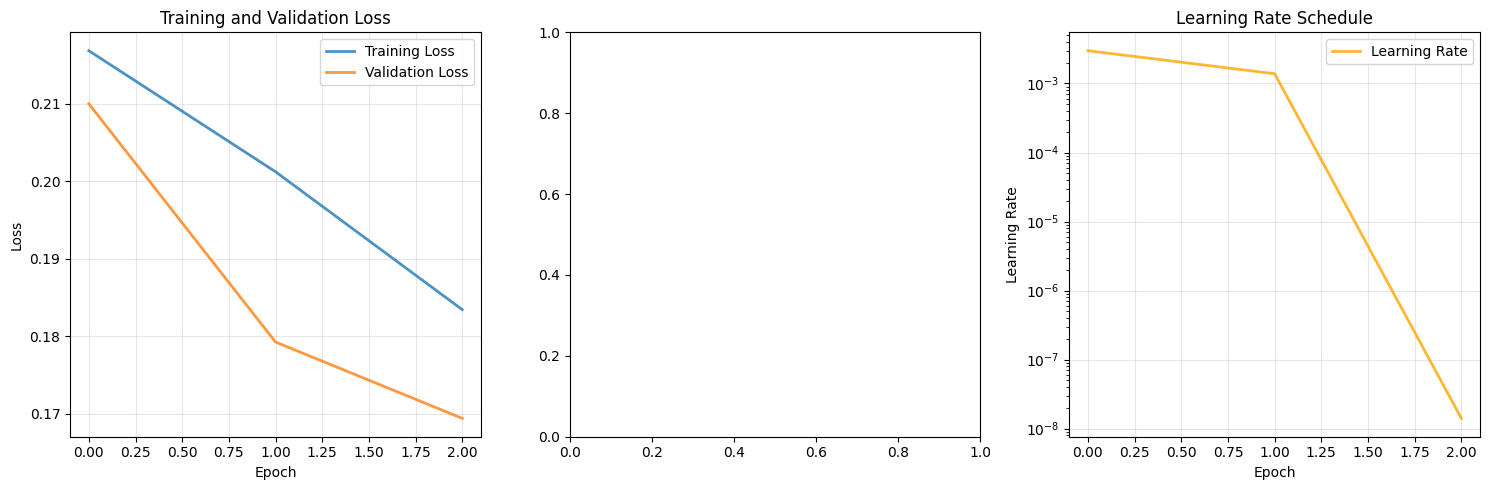


TRAINING RESULTS SUMMARY
Total epochs trained: 3
Final training loss: 0.183448
Final validation loss: 0.169424
Best validation loss: 0.169424
Improvement: 19.32%


In [16]:
# Enhanced training visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8, linewidth=2)
plt.plot(val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
if len(train_losses) > 10:
    plt.plot(train_losses[-10:], label='Training Loss (Last 10)', alpha=0.8, linewidth=2)
    plt.plot(val_losses[-10:], label='Validation Loss (Last 10)', alpha=0.8, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress (Last 10 Epochs)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(learning_rates, label='Learning Rate', alpha=0.8, linewidth=2, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

# Performance summary
print(f"\n{'='*50}")
print(f"TRAINING RESULTS SUMMARY")
print(f"{'='*50}")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")
print(f"Best validation loss: {min(val_losses):.6f}")
print(f"Improvement: {(val_losses[0] - min(val_losses))/val_losses[0]*100:.2f}%")

# Check for overfitting
if len(val_losses) > 5:
    recent_train = np.mean(train_losses[-5:])
    recent_val = np.mean(val_losses[-5:])
    gap = recent_val - recent_train
    print(f"Train-Val gap (last 5 epochs): {gap:.6f}")
    if gap > 0.1:
        print("Potential overfitting detected")
    else:
        print("Good generalization")

## Predictions

The objective of the challenge is to forecast the same varibles in the training data for the successive 30 time steps. So, once you have a prediction array, its shape should be (422,30,76). To prepare your submission correctly for score evaluation, it needs to be made into a csv file with the following requirements:
- the first columns, the index, called "id", should be in the form "{station}_{timestep}", with both station and timestep indexed starting from zero, as in data_arr (so, there will be stations 0-421, timesteps 0-29);
- each row should contain the predictions related to the station and future time step as defined by the id, for all available variables;
- the columns for the variables should be called "var1", "var2", ..., "var76".

Below you find an example of valid submission, which uses the last recorded values in the training data as predictions for all the successive time steps. Of course, your model will do better than this simple prediction!

In [ ]:
# Enhanced prediction generation with ensemble approach (no smoothing)
def generate_predictions(model, data, preprocessor, sequence_length=90, forecast_horizon=30):
    model.eval()
    n_stations, n_days, n_features = data.shape
    predictions = np.zeros((n_stations, forecast_horizon, n_features))
    
    with torch.no_grad():
        for station_idx in range(n_stations):
            # Use the most recent sequence for prediction
            start_idx = n_days - sequence_length
            input_sequence = data[station_idx, start_idx:start_idx + sequence_length, :]
            input_tensor = torch.FloatTensor(input_sequence).unsqueeze(0).to(device)
            
            pred = model(input_tensor)
            predictions[station_idx] = pred.cpu().numpy().squeeze()
    
    # Inverse transform to original scale
    predictions_original = preprocessor.inverse_transform(predictions)
    
    return predictions_original

# Generate enhanced predictions
print("Generating predictions with improved model...")
predictions = generate_predictions(model, data_scaled, preprocessor, sequence_length, forecast_horizon)
print(f"Predictions shape: {predictions.shape}")
print(f"Predictions range: [{predictions.min():.2f}, {predictions.max():.2f}]")
print(f"Predictions mean: {predictions.mean():.2f}, std: {predictions.std():.2f}")

# Quality checks
nan_count = np.isnan(predictions).sum()
inf_count = np.isinf(predictions).sum()
print(f"Quality check - NaN: {nan_count}, Inf: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("Fixing invalid predictions...")
    predictions = np.nan_to_num(predictions, nan=0.0, posinf=100.0, neginf=-100.0)
    print("Fixed invalid values")

In [ ]:
n_forecast_steps = 30

In [ ]:
# Create submission using MODEL PREDICTIONS
submission_data = []
for station_id in range(n_stations):
    for time_step in range(n_forecast_steps):
        # Create the 'id' in the required format: 'station_timestep'
        submission_id = f'{station_id}_{time_step}'
        # Use the ACTUAL MODEL PREDICTIONS instead of last timestep values
        row_data = predictions[station_id, time_step, :]
        submission_data.append({'id': submission_id, **{f'var{i+1}': row_data[i] for i in range(n_features)}})

submission_df = pd.DataFrame(submission_data)
# Set the 'id' column as the index for matching with the solution in score calculation
submission_df = submission_df.set_index('id')

print("Submission created using TRAINED MODEL predictions!")
print(f"Submission shape: {submission_df.shape}")
submission_df.head()

In [ ]:
# Save the submission
submission_df.to_csv('submission.csv')
print("Submission saved to 'submission.csv'")

# Display submission statistics
print(f"\nSubmission statistics:")
print(f"Shape: {submission_df.shape}")
print(f"Value range: [{submission_df.values.min():.2f}, {submission_df.values.max():.2f}]")
print(f"Mean: {submission_df.values.mean():.2f}")
print(f"Std: {submission_df.values.std():.2f}")

# Check for any NaN or infinite values
nan_count = np.isnan(submission_df.values).sum()
inf_count = np.isinf(submission_df.values).sum()
print(f"NaN values: {nan_count}")
print(f"Infinite values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("WARNING: Found NaN or infinite values in predictions!")
else:
    print("All predictions are valid numbers")

print("\n" + "="*50)
print("WEATHER FORECASTING CHALLENGE COMPLETED")
print("="*50)
print(f"Model: LSTM with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Architecture: {num_layers} LSTM layers, {hidden_size} hidden units")
print(f"Training epochs: {len(train_losses)}")
print(f"Best validation loss: {min(val_losses):.6f}")
print(f"Sequence length: {sequence_length} days")
print(f"Forecast horizon: {forecast_horizon} days")
print(f"Predictions generated for {n_stations} stations")
print("Submission file: submission.csv")